In [1]:
# Core libraries
import random
import math
from math import factorial, exp
import numpy as np
from scipy.stats import binom, poisson
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations, permutations
import itertools
from pathlib import Path

# Graph libraries
import rustworkx as rx
import networkx as nx
from rustworkx.visualization import mpl_draw

In [2]:
# Visualization settings
NS_PURPLE = "#8e44ad"  # Node color
NS_GREEN = "#2ecc71"   # Edge color
NS_ORANGE = "#FF9800"  # Highlight color

plt.rcParams['figure.figsize'] = (3, 2)
plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.edgecolor": "0.3",
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

# File paths
ROOT = Path.cwd().parent
DATADIR = ROOT/"data"

In [3]:
# Utility functions

def pprint(G):
    """Pretty print basic graph statistics."""
    print(f"Graph has {G.num_nodes()} nodes and {G.num_edges()} edges")

def convert_rustworkx_to_networkx(graph):
    """Convert a rustworkx PyGraph or PyDiGraph to a networkx graph."""
    edge_list = [(
        graph[x[0]], graph[x[1]],
        {'weight': x[2]}) for x in graph.weighted_edge_list()]

    if isinstance(graph, rx.PyGraph):
        if graph.multigraph:
            return nx.MultiGraph(edge_list)
        else:
            return nx.Graph(edge_list)
    else:
        if graph.multigraph:
            return nx.MultiDiGraph(edge_list)
        else:
            return nx.DiGraph(edge_list)

ER = rx.undirected_gnp_random_graph

In [6]:
import os

def set_seed(seed: int | None = None) -> int:
    """Set all relevant random seeds and return the seed used."""
    if seed is None:
        # or use secrets, or something else
        seed = int.from_bytes(os.urandom(4), "big")

    # Python's built-in RNG
    random.seed(seed)

    # NumPy legacy global RNG
    np.random.seed(seed)

    return seed



# Chapter 3: Random Networks

> **Network Science** by Albert-László Barabási  
> Companion Notebook using [RustWorkX](https://www.rustworkx.org/)

---

This notebook provides Python implementations of the key concepts from Chapter 3 of the Network Science textbook. We use the `rustworkx` library for efficient graph operations.

## 3.2 The Random Network Model

A random network consists of `N` nodes where each node pair is connected with probability `p`.

In [104]:
# G(N, p) Model: Each pair of N labeled nodes is connected with probability p 
set_seed(2)

N = 5
p = 0.1

possible_edges = [(u,v) for u,v in combinations(nodes, 2)]
edges = [e for e in possible_edges if random.random() < p]

print(f"Number of nodes: {N}")
print(f"With {N} nodes there are {len(possible_edges)} possible edges")
print(f"Our graph generated {len(edges)}: {edges}")

Number of nodes: 5
With 5 nodes there are 10 possible edges
Our graph generated 2: [(0, 3), (0, 4)]


In [115]:
# G(N, L) Model: N labeled nodes are connected with L randomly placed links 
set_seed(3)

N = 5
L = 2

n_possible_edges = math.comb(N, L)
link_1, link_2 = np.random.randint(0, n_possible_edges, L)

edges = [(u,v) for i, (u,v) in  
            enumerate(combinations(nodes, 2)) 
                if i in [link_1, link_2]]

print(f"Number of nodes: {N}")
print(f"With {N} nodes there are {n_possible_edges}")
print(f"Our graph generated {len(edges)}: {edges}")

Number of nodes: 5
With 5 nodes there are 10
Our graph generated 2: [(2, 4), (3, 4)]


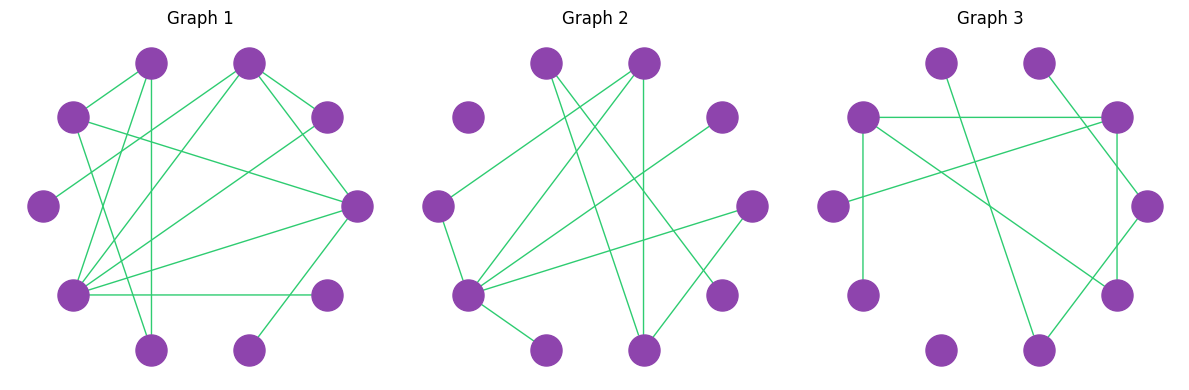

In [200]:
# Visual ER models with different realizations with parameters N, p
set_seed(4)

N, p = 10, .3

graphs = [rx.undirected_gnp_random_graph(N, p) for _ in range(3)]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, (g, ax) in enumerate(zip(graphs, axes)):
    layout = rx.circular_layout(g)
    ax.set_title(f"Graph {i+1}")
    mpl_draw(g, pos=layout, ax=ax, node_color=NS_PURPLE, edge_color=NS_GREEN, with_labels=False, node_size=500)
    ax.set_axis_off()
plt.tight_layout()

## 3.3 Number of Links

The probability that a random network has exactly `L` links is the product of three terms:

* The probability that `L` of the attempts to connect the `N(N-1)/2` pairs of nodes have resulted in a link, which is ${p}^L$.
* The probability that the remaining `N(N-1)/2 - L` attempts have not resulted in a link, which is $(1-p)^{N(N-1)/2-L}$.
* A combinational factor $$
\binom{\frac{N(N-1)}{2}}{L}
$$
counting the number of different ways we can place `L` links among `N(N-1)/2` node pairs

We can therefore write the probability that a particular realization of a
random network has exactly $L$ links as

$$
p_L =
\binom{\frac{N(N-1)}{2}}{L}
\, p^L (1 - p)^{\frac{N(N-1)}{2} - L}
\tag{3.1}
$$


In [163]:
# the probability that a particular realization of a random network has exactly L links

N, p = 10, 0.1
L = 5

n_possible_edges = math.comb(N, 2)
n_possible_L = math.comb(n_possible_edges, L)

p_L = np.power(p, L)
p_not_L = np.power(1-p, n_possible_edges - L)

# prob of exactly L links
pl = n_possible_L * (p_L * p_not_L)
print(pl)

0.1805867676164421


In [164]:
def prob_l_in_random_network(N, p, L):
    n_possible_edges = math.comb(N, 2)
    n_possible_L = math.comb(n_possible_edges, L)
    
    p_L = np.power(p, L)
    p_not_L = np.power(1-p, n_possible_edges - L)
    
    pl = n_possible_L * (p_L * p_not_L)
    return pl

In [165]:
prob_l_in_random_network(10, 0.1, 5)

np.float64(0.1805867676164421)

#### The expected number of links in a random graph is given by
$$
\langle L \rangle
= \sum_{L=0}^{\frac{N(N-1)}{2}} L \, p_L
= p \, \frac{N(N-1)}{2}
$$

In [229]:
# binomial expectation of links
N, p = 10, .1

n_possible_edges = math.comb(N, 2) # N(N-1)/2
expected_edges = p*n_possible_edges # p * N(N-1)/2

print(f"Using the binomail distribution, the expected number of links: {expected_edges}")

Using the binomail distribution, the expected number of links: 4.5


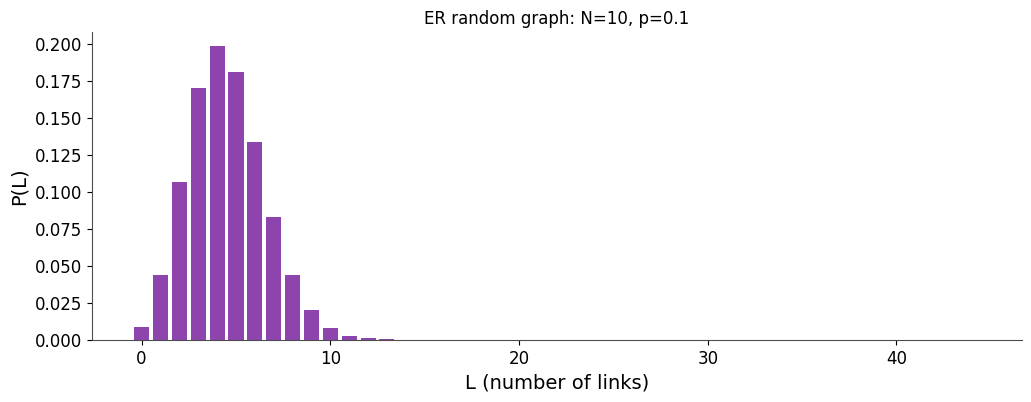

In [219]:
N, p = 10, .1

n_possible_edges = math.comb(N, 2)
Ls = list(range(n_possible_edges))

dist = [prob_l_in_random_network(N, p, l) for l in Ls]

pmf = np.array(dist)

plt.figure(figsize=(12,4))
plt.bar(Ls, pmf, color=NS_PURPLE)
plt.xlabel("L (number of links)")
plt.ylabel("P(L)")
plt.title(f"ER random graph: N={N}, p={p}")
plt.show()

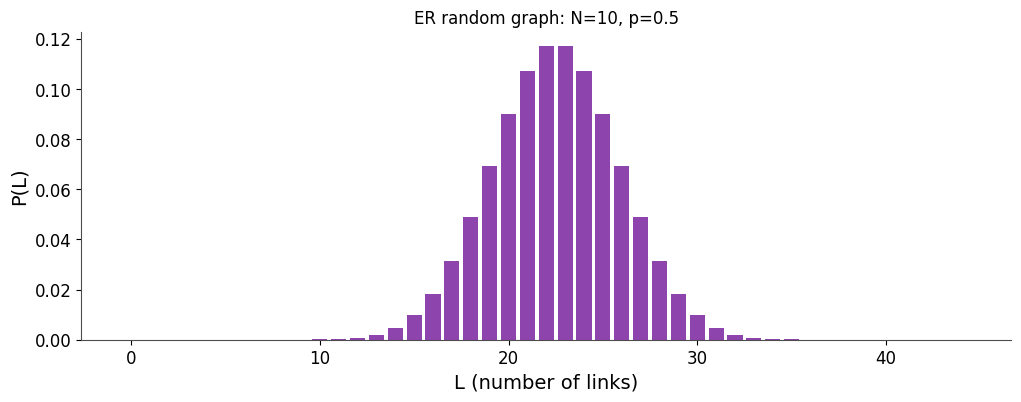

In [205]:
N, p = 10, .5

n_possible_edges = math.comb(N, 2)
Ls = list(range(n_possible_edges))

dist = [prob_l_in_random_network(N, p, l) for l in Ls]

pmf = np.array(dist)

plt.figure(figsize=(12,4))
plt.bar(Ls, pmf, color=NS_PURPLE)
plt.xlabel("L (number of links)")
plt.ylabel("P(L)")
plt.title(f"ER random graph: N={N}, p={p}")
plt.show()

In [206]:
# expected number of links is where p is the greatest
idx = np.argmax(dist)
idxs = [idx-1, idx, idx+1]
ps = pmf[idxs]
print(f"Emperically, the number of links with the highest probability:\n {idxs}")
print(f"{ps}")

Emperically, the number of links with the highest probability:
 [np.int64(21), np.int64(22), np.int64(23)]
[0.10725375 0.11700409 0.11700409]


#### The average degree of a random network is given by
$$
\langle k \rangle
= \frac{2 \langle L \rangle}{N}
= p (N - 1)
$$

In [230]:
N, p = 10, .25

n_possible_edges = math.comb(N, 2) # N(N-1)/2
expected_links = p*n_possible_links # p * N(N-1)/2

# 2*expected_links / N
# p(N-1)
assert p*(N-1) == 2*expected_links / N

# 3.4 Degree Distribution
In a given realization of a random network some nodes gain numerous links, while others acquire only a few or no links. These differences are captured by the degree distribution, ${p_k}$, which is the probability that a randomly chosen node has degree ${k}$. In this section we derive ${p_k}$ for a random network and discuss its properties.

## 3.4.1 Binomial Distribution
The degree distribution of a random network follows the binomial distribution
$$
p_k = \binom{N-1}{k} p^k (1 - p)^{N-1-k}
$$

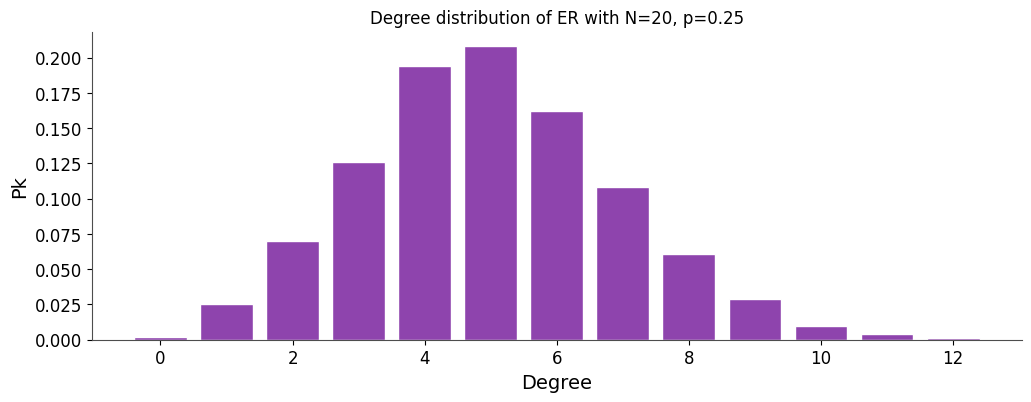

In [246]:
N, p = 20, .25

# simulates the number of edges in 1000 ER graphs
sample = np.random.binomial(N, p, 1000)
vals, counts = np.unique(sample, return_counts=True)
pk = counts / counts.sum()

plt.figure(figsize=(12,4))
plt.bar(vals, pk, color=NS_PURPLE, edgecolor='white')
plt.ylabel("Pk")
plt.xlabel("Degree")
plt.title(f"Degree distribution of ER with N={N}, p={p}")
plt.show()

## 3.4.2 Poisson Distribution
Most real networks are sparse, meaning that for them ${\langle k \rangle} << N$. In this limit the degree distribution is well approximated by the Poisson distribution 
$$
p_k =  e^{-\langle k \rangle} \frac{\langle k \rangle^{k}}{k!}
$$

##### Review Poisson basics

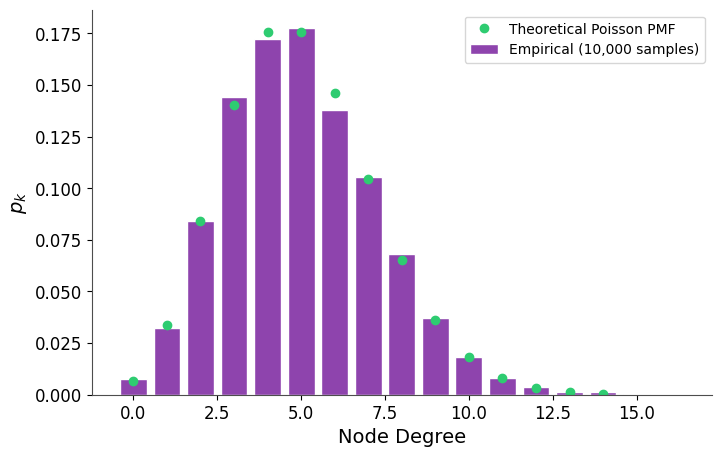

In [375]:
"""
A sample of 10,000 node degrees from the theoretical degree distribution 
of an random graph graph whose expected degree is 5 and <k> << N
"""
set_seed(11)
average_degree = 5
node_degrees = np.random.poisson(average_degree, 10000)

# empirical simulation
values, counts = np.unique(node_degrees, return_counts=True)
emp_p = counts / counts.sum()

ks = np.arange(0, 15)
pmf = np.array([poisson.pmf(k, average_degree) for k in ks])

plt.figure(figsize=(8, 5))
plt.bar(values, emp_p, color=NS_PURPLE, edgecolor="white", label="Empirical (10,000 samples)")
plt.plot(k, pmf, color=NS_GREEN, marker="o", linestyle="none", label="Theoretical Poisson PMF")
plt.xlabel("Node Degree")
plt.ylabel(r"$p_k$")
plt.legend()
plt.show()

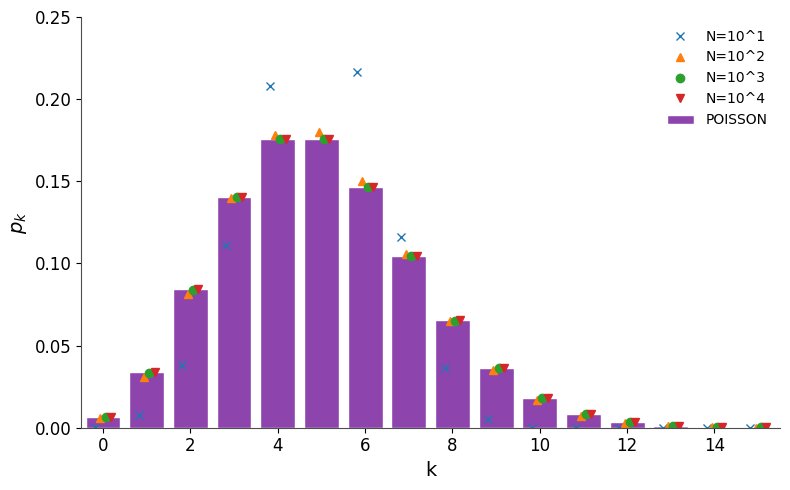

In [376]:
avg_degree = 5
Ns = [10**i for i in range(1, 5)]  # 10, 100, 1000, 10000
ks = np.arange(0, 26)

pk_poisson = poisson.pmf(ks, mu=avg_degree)

plt.figure(figsize=(8, 5))
plt.bar(ks, pk_poisson, label="POISSON", color=NS_PURPLE, edgecolor="white")

markers = ["x", "^", "o", "v"]
# small fixed offsets so points don't overlap (deterministic "jitter")
offsets = np.linspace(-0.18, 0.18, num=len(Ns))

for (N, m, dx) in zip(Ns, markers, offsets):
    # for any node in a graph there are N-1 other nodes (not N)
    n = N - 1
    # recover the p from given <k> and n
    p = avg_degree / n
    pk_binom = binom.pmf(ks, n=n, p=p)

    plt.plot(
        ks + dx, pk_binom,
        linestyle="none", marker=m, markersize=6,
        label=f"N=10^{int(np.log10(N))}"
    )

plt.xlabel("k")
plt.ylabel(r"$p_k$")
plt.ylim(0, 0.25)
plt.xlim(-0.5, 15.5)
plt.legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.show()

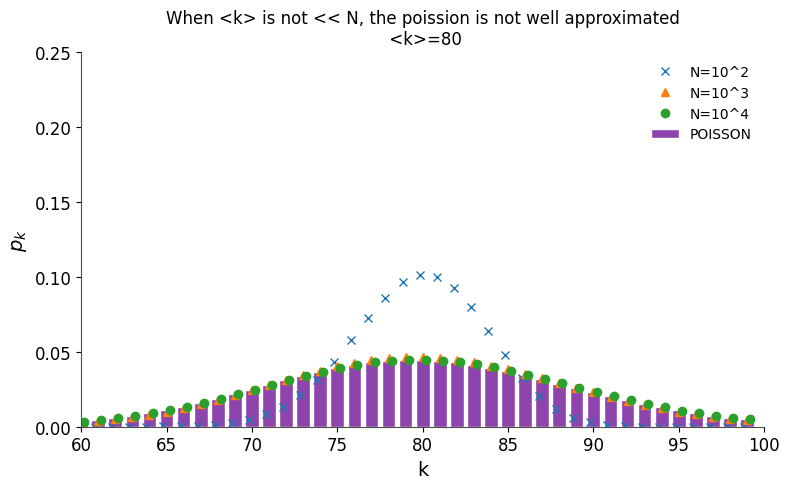

In [374]:
avg_degree = 80
Ns = [10**i for i in range(2, 5)]  # 10, 100, 1000, 10000
ks = np.arange(40, 100)

pk_poisson = poisson.pmf(ks, mu=avg_degree)

plt.figure(figsize=(8, 5))
plt.bar(ks, pk_poisson, label="POISSON", color=NS_PURPLE, edgecolor="white")

markers = ["x", "^", "o", "v"]
# small fixed offsets so points don't overlap (deterministic "jitter")
offsets = np.linspace(-0.18, 0.18, num=len(Ns))

for (N, m, dx) in zip(Ns, markers, offsets):
    # for any node in a graph there are N-1 other nodes (not N)
    n = N - 1
    # recover the p from given <k> and n
    p = avg_degree / n
    pk_binom = binom.pmf(ks, n=n, p=p)

    plt.plot(
        ks + dx, pk_binom,
        linestyle="none", marker=m, markersize=6,
        label=f"N=10^{int(np.log10(N))}"
    )

plt.title("When <k> is not << N, the poission is not well approximated\n <k>=80")
plt.xlabel("k")
plt.ylabel(r"$p_k$")
plt.ylim(0, 0.25)
plt.xlim(60, 100)
plt.legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.show()

## 3.5 Real Networks are Not Poisson
As the degree of a node in a random network can vary between 0 and N-1, we must ask, how big are the differences between the node degrees in a particular realization of a random network? That is, **can high degree nodes coexist with small degree nodes?** We address these questions by estimating the size of the largest and the smallest node in a random network.

## 3.5 The Evolution of a Random Network
One would expect that the largest component grows gradually from ${N_G} = 1$ to ${N_G} = N$ if ${\langle k \rangle}$ increases from ${0}$ to ${N-1}$. Yet, this is not the case: ${N_G/N}$ remains zero for small ${\langle k \rangle}$, indicating the lack of a large cluster. Once ${\langle k \rangle}$ exceeds a critical value, ${N_G/N}$ increases, signaling the rapid emergence of a large cluster that we call the giant component

In [93]:
# calculate thresholds
N = 100

# ER G(N,p) regimes (Network Science §3.4.2-ish)
# Relationship: ⟨k⟩ = p (N-1) ≈ pN for large N.
# Key thresholds:
#   ⟨k⟩ < 1       (p < 1/N)       : subcritical (no giant component)
#   ⟨k⟩ = 1       (p = 1/N)       : critical point
#   ⟨k⟩ > 1       (p > 1/N)       : supercritical (giant component emerges)
#   ⟨k⟩ > ln N    (p > ln N / N)  : connected w.h.p. (graph becomes connected)

regimes = [
    {"label": "subcritical",   "avg_degree": 0.5,  "threshold": "p < 1/N"},
    {"label": "critical",      "avg_degree": 1.0,  "threshold": "p = 1/N"},
    {"label": "supercritical", "avg_degree": 3.75, "threshold": "p > 1/N"},
    {"label": "connected",     "avg_degree": 5.25, "threshold": "p > ln(N)/N"},
]

# Convert ⟨k⟩ to p using ⟨k⟩ = p (N-1)
for r in regimes:
    r["p"] = r["avg_degree"] / (N - 1)

def largest_component_fraction(g: rx.PyGraph) -> float:
    largest = max(rx.connected_components(g), key=len)
    return len(largest) / g.num_nodes()

for r in regimes:
    g = rx.undirected_gnp_random_graph(N, r["p"], seed=42)
    gcc = largest_component_fraction(g)
    is_conn = rx.is_connected(g)

    print(
        f"{r['label']:>13} | ⟨k⟩={r['avg_degree']:<4} | p={r['p']:.4f} | "
        f"{r['threshold']:<10} | GCC={gcc:.2f} | connected={is_conn}"
    )

  subcritical | ⟨k⟩=0.5  | p=0.0051 | p < 1/N    | GCC=0.04 | connected=False
     critical | ⟨k⟩=1.0  | p=0.0101 | p = 1/N    | GCC=0.11 | connected=False
supercritical | ⟨k⟩=3.75 | p=0.0379 | p > 1/N    | GCC=0.98 | connected=False
    connected | ⟨k⟩=5.25 | p=0.0530 | p > ln(N)/N | GCC=1.00 | connected=True


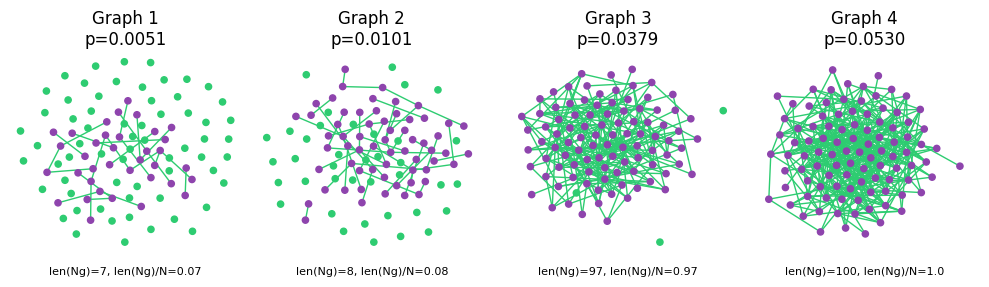

In [103]:
# plot
ps = [r.get('p') for r in regimes]
graphs = [rx.undirected_gnp_random_graph(N, p) for p in ps]

fig, axes = plt.subplots(1, 4, figsize=(10,3))
for i, (g, ax, p) in enumerate(zip(graphs, axes, ps)):
    layout = rx.spring_layout(g, k=.85, repulsive_exponent=5)
    ax.set_title(f"Graph {i+1}\np={p:.4f}")
    colors = [
        NS_PURPLE if any(g.neighbors(i)) else NS_GREEN
        for i in g.node_indices()
    ]
    Ng, *_ = sorted(rx.connected_components(g), key=len, reverse=True)
    ng_text = f"{len(Ng)=}, {len(Ng)/N=}"
    ax.text(
        0.5, -0.08, ng_text,
        transform=ax.transAxes,
        ha="center", va="top",
        fontsize=8
    )
    mpl_draw(g, pos=layout, ax=ax, node_color=colors, edge_color=NS_GREEN, with_labels=False, node_size=20)
    ax.set_axis_off()
plt.tight_layout()

## Box 3.5 Network Evolution in Graph Theory

$p \sim N^z$

the symbol $\sim$ is read as “asymptotically proportional to” or “scales like”.

So

$p \sim N^z$

means:

As $𝑁 → ∞$,  $𝑝$ grows on the order of ${𝑁^z}$

More precisely:

$\frac{p}{N^z} ⟶ 𝐶$ for some constant $𝐶 > 0$

A subgraph $H$ appears when the expected number of copies of $H$ transitions from $0$ to $\infty$  as $N -> \infty$.

### 1. What the book means by “threshold”

When the book refers to *threshold probabilities*, it is **not** referring to the mere existence of edges.  
Instead, it refers to the emergence of **specific finite subgraphs** (motifs) as the network grows.

In the Erdős–Rényi model with

$$
p(N) \sim N^{z}, \quad z < 0
$$

a *threshold* corresponds to the value of \(z\) at which a given subgraph appears with high probability as  
\(N \to \infty\).

Each graph property has its **own threshold exponent**.

---

## 2. The organizing principle

The central idea is:

> A subgraph \(H\) appears when the expected number of copies of \(H\) transitions from  
> going to zero to diverging as \(N \to \infty\).

Thus, different motifs (edges, paths, trees, cycles, cliques) appear at **different values of \(z\)**.

---

## 3. Why \(z = -3/2\) is a real threshold

Consider the simplest structure beyond a single edge:  
a **path of length 2**, involving 3 nodes and 2 edges.

- Number of ways to choose 3 nodes: \(\sim N^3\)
- Probability the two required edges exist: \(p^2 \sim N^{2z}\)

The expected number of such paths scales as:

$$
\mathbb{E}[\text{paths of length 2}]
\sim N^3 \cdot N^{2z}
= N^{3 + 2z}
$$

This quantity transitions from vanishing to diverging when:

$$
3 + 2z = 0
\quad \Rightarrow \quad
z = -\frac{3}{2}
$$

Therefore:

- For \(z < -3/2\): almost surely **no paths of length ≥ 2** exist  
- For \(z > -3/2\): paths connecting three or more nodes appear

This explains why the book identifies \(z = -3/2\) as the point where networks move beyond isolated edges.

---

## 4. Why the earlier “edge threshold” is different

If we instead ask:

> Do any edges exist at all?

Then we look at the expected number of edges:

$$
\mathbb{E}[L] = \binom{N}{2} p
\sim \frac{N^2}{2} N^{z}
= N^{2+z}
$$

This gives a threshold at:

$$
z = -2
$$

- For \(z < -2\): the graph is almost surely empty  
- For \(z = -2\): a finite number of isolated edges appear  

This threshold concerns **edge existence**, not higher-order structure, so it does not contradict the book’s discussion.

---

## 5. Interpreting the emergence of larger trees

A tree of order \(k\) has:
- \(k\) nodes
- \(k-1\) edges

The expected number of such trees scales as:

$$
N^k \cdot p^{k-1}
\sim N^{k + (k-1)z}
$$

Setting the exponent to zero gives the threshold:

$$
k + (k-1)z = 0
\quad \Rightarrow \quad
z = -\frac{k}{k-1}
$$

Examples:
- \(k = 3 $\Rightarrow$ z = -3/2\)
- \(k = 4 $\Rightarrow$ z = -4/3\)

This matches the progression described in the book.

---

## 6. Trees of all orders and cycles at \(z = -1\)

At \(z = -1\):

$$
\langle k \rangle \sim pN \sim O(1)
$$

This is the classic Erdős–Rényi critical point:

- Trees of all finite sizes appear  
- Cycles begin to emerge  
- The graph remains sparse but structurally rich  

This precedes the formation of a giant connected component.

---

## 7. The clean mental model

A compact way to think about ER graph evolution under \(p(N) \sim N^{z}\):

- \(z < -2\): no edges  
- \(z = -2\): isolated edges appear  
- \(-2 < z < -3/2\): isolated edges dominate  
- \(z = -3/2\): paths of length 2 appear  
- \(-3/2 < z < -1\): small trees emerge  
- \(z = -1\): trees of all orders and cycles appear  

Each transition corresponds to the emergence of a new class of subgraphs with high probability.


#### scratch work

In [46]:
import scipy.sparse as sp

def rx_to_csr_adjacency(G, *, dtype=np.int64):
    n = G.num_nodes()
    edges = G.edge_list()  # list of (u, v) :contentReference[oaicite:2]{index=2}
    if not edges:
        return sp.csr_matrix((n, n), dtype=dtype)

    u = np.fromiter((e[0] for e in edges), count=len(edges), dtype=np.int64)
    v = np.fromiter((e[1] for e in edges), count=len(edges), dtype=np.int64)
    data = np.ones(len(edges), dtype=dtype)

    # undirected: add both (u,v) and (v,u)
    rows = np.concatenate([u, v])
    cols = np.concatenate([v, u])
    data = np.concatenate([data, data])

    A = sp.coo_matrix((data, (rows, cols)), shape=(n, n), dtype=dtype).tocsr()
    A.setdiag(0)        # no self-loops
    A.eliminate_zeros()
    return A

In [48]:
N = np.power(10, 3)
z = -1.4
p = np.power(N, z)
G =  rx.undirected_gnp_random_graph(N, p)
A = rx_to_csr_adjacency(G)

In [52]:
A3 = A @ A @ A
triangles = int(A3.diagonal().sum() // 6)
print(triangles)

0


In [59]:
Ns = [np.power(10, i) for i in range(1, 6)]
z = -1.4

for N in Ns:
    p = N**z
    G =  rx.undirected_gnp_random_graph(N, p)
    A = rx_to_csr_adjacency(G)
    A2 = A @ A 
    wedges = int(A2.diagonal().sum() // 2)
    print(wedges)

2
10
32
125
473


In [54]:
A3 = A @ A @ A
type(A3)

scipy.sparse._csr.csr_matrix

In [45]:

# triangles should appear above -1.33
z = -1.4
p = np.power(N, z)
G =  rx.undirected_gnp_random_graph(N, p)
A = rx.adjacency_matrix(G)
print(np.trace(np.linalg.matrix_power(A, 3)) // 6)

0.0


In [40]:
pprint(G)

Graph has 1000 nodes and 12 edges


In [41]:
A = rx.adjacency_matrix(G)
A.shape

(1000, 1000)

In [44]:
np.trace(np.linalg.matrix_power(A, 3)) // 6

np.float64(0.0)

In [42]:
# count edges
np.trace(A @ A) // 2

np.float64(12.0)

In [43]:
np.trace(A @ A @ A) // 3

np.float64(0.0)

In [25]:
A.sum(axis=1).sum()

np.float64(28.0)

In [201]:
np.power(N, -1.5)

np.float64(0.03162277660168379)

In [132]:
zs = -1 * np.array([np.inf, 2, 3/2, 4/3, 5/4, 1, 2/3, 1/2])
Ns = [np.power(10, i) for i in range(1, 7)]

In [152]:
results = []
for z in zs[1:]:  # skip -inf for plotting
    a = [float(np.power(n, z)) for n in Ns]
    results.append(a)

In [158]:
pd.DataFrame(results, index=zs[1:], columns=Ns).T

,-2.000000,-1.500000,-1.333333,-1.250000,-1.000000,-0.666667,-0.500000
10,1.000000e-02,3.162278e-02,4.641589e-02,5.623413e-02,0.100000,0.215443,0.316228
100,1.000000e-04,1.000000e-03,2.154435e-03,3.162278e-03,0.010000,0.046416,0.100000
1000,1.000000e-06,3.162278e-05,1.000000e-04,1.778279e-04,0.001000,0.010000,0.031623
10000,1.000000e-08,1.000000e-06,4.641589e-06,1.000000e-05,0.000100,0.002154,0.010000
100000,1.000000e-10,3.162278e-08,2.154435e-07,5.623413e-07,0.000010,0.000464,0.003162
1000000,1.000000e-12,1.000000e-09,1.000000e-08,3.162278e-08,0.000001,0.000100,0.001000


Graph has 10 nodes and 12 edges


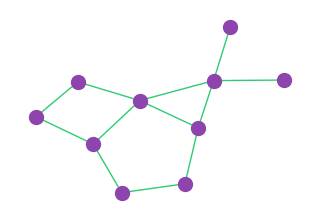

In [184]:
results = []
for z in zs[1:]:  # skip -inf for plotting
    a = [float(np.power(n, z)) for n in Ns]
    results.append(a)

df = pd.DataFrame(results, index=zs[1:], columns=Ns).T

# N = 10, p = .01
N, p = df.index[0], df.iloc[0,0] + 

G = rx.undirected_gnp_random_graph(N, p)
pprint(G)
mpl_draw(G,node_color=NS_PURPLE, edge_color=NS_GREEN, with_labels=False, node_size=100)

In [175]:
df[df.index==10]

,-2.000000,-1.500000,-1.333333,-1.250000,-1.000000,-0.666667,-0.500000
10,0.01,0.031623,0.046416,0.056234,0.1,0.215443,0.316228


## Testing

In [73]:
def _neighbor_sets(G):
    # precompute neighbors once per graph for set intersections
    return [set(G.neighbors(i)) for i in G.node_indices()]

def exists_edge(G) -> bool:
    return G.num_edges() > 0

def exists_wedge_len2(G) -> bool:
    # a length-2 path exists iff some node has degree >= 2
    return any(G.degree(v) >= 2 for v in G.node_indices())

def exists_3star(G) -> bool:
    # 4-node tree representative: K_{1,3}
    return any(G.degree(v) >= 3 for v in G.node_indices())

def exists_4star(G) -> bool:
    # 5-node tree representative: K_{1,4}
    return any(G.degree(v) >= 4 for v in G.node_indices())

def exists_triangle(G) -> bool:
    nbrs = _neighbor_sets(G)
    for u, v in G.edge_list():
        if nbrs[u].intersection(nbrs[v]):
            return True
    return False

def exists_K4(G) -> bool:
    # K4 exists if there is an edge (u,v) with two common neighbors (a,b)
    # such that (a,b) is also an edge.
    nbrs = _neighbor_sets(G)
    edge_set = {tuple(sorted(e)) for e in G.edge_list()}

    for u, v in G.edge_list():
        common = nbrs[u].intersection(nbrs[v])
        if len(common) < 2:
            continue
        for a, b in combinations(common, 2):
            if (min(a, b), max(a, b)) in edge_set:
                return True
    return False


all_tests = [exists_edge, exists_wedge_len2, exists_3star, exists_4star, exists_triangle, exists_K4]

In [92]:
import numpy as np
import rustworkx as rx

ER = rx.undirected_gnp_random_graph

# see appendix for reivew of tests
motif_tests = [
    ("edge", exists_edge),
    ("wedge (len-2 path)", exists_wedge_len2),
    ("3-star (K1,3)", exists_3star),
    ("4-star (K1,4)", exists_4star),
    ("triangle", exists_triangle),
    ("K4", exists_K4),
]

zs = -np.array([2, 3/2, 4/3, 5/4, 1, 2/3, 1/2], dtype=float)
Ns = [10**i for i in range(1, 3)]
trials = 20
seed0 = 0

for z in zs:
    print(f"\n=== z = {z:.3f}  (p(N) = N^z) ===")
    for N in Ns:
        p = float(N**z)

        # indicator matrix: shape (trials, n_tests)
        indicators = np.zeros((trials, len(motif_tests)), dtype=int)

        for t in range(trials):
            # make the seed unique per (z, N, t)
            seed = seed0 + (hash((float(z), int(N))) & 0xFFFF_FFFF) + t
            G = ER(N, p, seed=seed)

            indicators[t, :] = [int(fn(G)) for _, fn in motif_tests]

        mean_met = indicators.sum(axis=1).mean()
        presence_rate = indicators.mean(axis=0)  # per motif, fraction of trials present

        # concise summary line
        print(f"N={N:>6}, p={p:.2e} | mean motifs present = {mean_met:.2f} / {len(motif_tests)}")

        # optional: show per-motif presence rates (nice for a book)
        # rates = ", ".join(f"{name}:{rate:.2f}" for (name, _), rate in zip(motif_tests, presence_rate))
        # print(f"  presence rates: {rates}")



=== z = -2.000  (p(N) = N^z) ===
N=    10, p=1.00e-02 | mean motifs present = 0.30 / 6
N=   100, p=1.00e-04 | mean motifs present = 0.40 / 6

=== z = -1.500  (p(N) = N^z) ===
N=    10, p=3.16e-02 | mean motifs present = 1.05 / 6
N=   100, p=1.00e-03 | mean motifs present = 1.45 / 6

=== z = -1.333  (p(N) = N^z) ===
N=    10, p=4.64e-02 | mean motifs present = 1.40 / 6
N=   100, p=2.15e-03 | mean motifs present = 1.90 / 6

=== z = -1.250  (p(N) = N^z) ===
N=    10, p=5.62e-02 | mean motifs present = 1.40 / 6
N=   100, p=3.16e-03 | mean motifs present = 2.55 / 6

=== z = -1.000  (p(N) = N^z) ===
N=    10, p=1.00e-01 | mean motifs present = 2.20 / 6
N=   100, p=1.00e-02 | mean motifs present = 3.90 / 6

=== z = -0.667  (p(N) = N^z) ===
N=    10, p=2.15e-01 | mean motifs present = 4.45 / 6
N=   100, p=4.64e-02 | mean motifs present = 5.05 / 6

=== z = -0.500  (p(N) = N^z) ===
N=    10, p=3.16e-01 | mean motifs present = 5.15 / 6
N=   100, p=1.00e-01 | mean motifs present = 6.00 / 6


## 3.7 Real Networks are Supercritical
Two predictions of random network theory are of direct importance for real networks:

Once the average degree exceeds ‹k› = 1, a giant component should emerge that contains a finite fraction of all nodes. Hence only for ‹k› › 1 the nodes organize themselves into a recognizable network.
For ‹k› › lnN all components are absorbed by the giant component, resulting in a single connected network.

In [132]:
!ls $DATADIR

actor.edgelist.txt	    internet.edgelist.txt    powergrid.edgelist.txt
citation.edgelist.txt	    metabolic.edgelist.txt   protein.edgelist.txt
collaboration.edgelist.txt  networks.zip	     www.edgelist.txt
email.edgelist.txt	    phonecalls.edgelist.txt


In [38]:
!head $DATADIR/internet.edgelist.txt -n 5

0	1
0	111
0	219
0	337
0	740


In [47]:
file = 'internet.edgelist.txt'
dataset = DATADIR/file

with dataset.open() as f:
    data = [tuple(l.strip().split('\t'))
            for l in f.readlines()]
    
f = lambda x: tuple(map(int, x))

edges = list(map(f, data))
nodes = list(set(itertools.chain.from_iterable(data)))

G = rx.PyGraph()
G.add_nodes_from(nodes)
G.add_edges_from_no_data(edges)

N = len(nodes)
L = len(edges)

# avg_degree = sum(G.degree(i) for i in G.node_indexes()) / G.num_nodes()
avg_degree = 2 * L / N
lnN = np.log(N)

print('Internet Data')
print(f"Nodes (N):\t {len(nodes)}")
print(f"Edges (L):\t {len(edges)}")
print(f"<k>:\t\t {avg_degree:.2f}")
print(f"lnN:\t\t {lnN:.2f}")

Internet Data
Nodes (N):	 192244
Edges (L):	 609066
<k>:		 6.34
lnN:		 12.17


## 3.8 Small Worlds
By small in the "small world phenomenon" we mean that the average path length or the diameter depends logarithmically on the system size. Hence, “small” means that **the average distance between two nodes $\langle d \rangle$** is proportional to $lnN$, rather than $N$ or some power of $N$.

These examles with be using the following random graph for clarity across cells
$$N = 1000$$
$$p = 0.01$$
$$seed = 67$$

In [80]:
N, p, seed = 1000, .01, 67
G = rx.undirected_gnp_random_graph(N, p, seed)
pprint(G)
print(f"avg_degree: {2 * G.num_edges()/G.num_nodes():.2f}")

Graph has 1000 nodes and 4994 edges
avg_degree: 9.99


To find the total number of nodes up to $d$ distance away
$$
N(d) \approx 1 + \langle k \rangle + \langle k \rangle^2 + \cdots + \langle k \rangle^d
= \frac{\langle k \rangle^{d+1} - 1}{\langle k \rangle - 1}
$$

In [66]:
def nodes_within_distance(k: float, d: int) -> float:
    """
    Expected number of nodes within distance d in the simple branching approximation:
        1 + k + k^2 + ... + k^d
    (includes the starting node at distance 0)
    """
    if np.isclose(k, 1.0):
        return d + 1  # avoid dividing by ~0 in the closed form
    return (k**(d + 1) - 1) / (k - 1)

In [79]:
avg_degree = 10
diameter = 5 # guess at a diameter

# our estimage of N
nodes_d_distance_away = nodes_within_distance(avg_degree, diameter)

print(f"Estimated N in G using:")
print(f"{avg_degree=}, {diameter=}")
print(f"N(d) = nodes in G = N = {nodes_d_distance_away:.2f}")

Estimated N in G using:
avg_degree=10, diameter=5
N(d) = nodes in G = N = 111111.00


N(d) can not exceed N. We can identify the maximum distance, $d_{max}$, or the network’s diameter by setting

$$
N(d_{max}) \approx N
$$

Assuming that $\langle k \rangle >> 1$ , drop the -1 term from `nodes_within_distance` leaving us with

$$
\langle k \rangle^{d_{max}} \approx N
$$

Take the log of both sides and divide by $ln \langle k \rangle$ and we have an approximation of $d_{max}$ as

$$
d_{max} \approx \frac{ln N}{ln \langle k \rangle}
$$

As derived, this predicts the scaling of the network diameter, $d_{max}$, with the size of the system, $N$. Yet, for most networks the above offers a better approximation to the **average** distance between two randomly chosen nodes, $\langle d \rangle$, than to $d_{max}$. This is because $d_{max}$ is often **dominated by a few extreme paths**, while $\langle d \rangle$ is **averaged over all node pairs**, a process that supresses the fluctuations. Hence typically the small world property is defined by 

$$
\langle d \rangle \approx \frac{ln N}{ln \langle k \rangle}
$$


In [74]:
# functions for this example
def avg_degree_fn(G):
    # For an undirected graph, ⟨k⟩ = 2L/N
    return 2 * G.num_edges() / G.num_nodes()

def expected_within_distance(k: float, d: int) -> float:
    """
    Expected number of nodes within distance d in the simple branching approximation:
        1 + k + k^2 + ... + k^d
    (includes the starting node at distance 0)
    """
    if np.isclose(k, 1.0):
        return d + 1  # avoid dividing by ~0 in the closed form
    return (k**(d + 1) - 1) / (k - 1)

def expected_at_distance(k: float, d: int) -> float:
    """
    Expected number of nodes at *exactly* distance d (the d-th BFS layer)
    under the same approximation: k^d.
    """
    return k**d

def largest_component(G):
    comps = rx.connected_components(G) 
    comp = max(comps, key=len)
    return G.subgraph(list(comp))

def graph_diameter_unweighted(G):
    apsp_lengths = rx.all_pairs_dijkstra_path_lengths(G, edge_cost_fn=lambda _: 1)
    
    diameter = max(
        dist
        for src, mapping in apsp_lengths.items()
        for dist in mapping.values()
    )
    return diameter

In [75]:
set_seed(67)

N, p = 1000, 0.01
G = rx.undirected_gnp_random_graph(N, p, seed=67)

avg_degree = avg_degree_fn(G)
# by definition diameter is the max, shortest path among all pairs of nodes
max_shortest_path = graph_diameter_unweighted(G)
# find <d> by taking the average of all shortest path pairs
emperical_avg_d = rx.unweighted_average_shortest_path_length(G)
# we predict <d> ~ d_max
pred_avg_d = np.log(G.num_nodes()) / np.log(avg_degree_fn(G))

print(f"Number of nodes: {G.num_nodes():,}")
print(f"Average Degree: {avg_degree:.3f}")
print(f"Max shortest path (diameter): {max_shortest_path}")
print(f"Measured average distance ⟨d⟩:  {emperical_avg_d:.3f}")
print(f"Predicted ⟨d⟩ ~ lnN/ln⟨k⟩:      {pred_avg_d:.3f}")


assert np.isclose(avg_degree**pred_avg_d, N, .01)

Number of nodes: 1,000
Average Degree: 9.988
Max shortest path (diameter): 5.0
Measured average distance ⟨d⟩:  3.254
Predicted ⟨d⟩ ~ lnN/ln⟨k⟩:      3.002


Finding the average path length between all nodes in a large network is not always possible. Using knowlege of the average degree and size of the network we can estimate that average. This is the logic driving 6 degrees of Kevin Bacon (or anyone of earth)!